In [1]:
import os
import numpy as np
np.set_printoptions(precision=2, suppress=True)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from utils import *
from metrics import ChangeTypeAccuracyMatrix
from models.TSSCD import *
import torch.nn.functional as F

device = device_on()
plt.rcParams['font.family'] = ['Arial']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False

Uisng cuda device


In [2]:
ps = ['SD', 'JS', 'SH', 'ZJ', 'FJ', 'GDGX']
for p in ps:
    ds = np.load(f'models/model_data/dataset/1037/1/{p}_tralid.npy')
    ds_test = np.load(f'models/model_data/dataset/1037/1/{p}_test.npy')
    print(p, ds.shape, ds_test.shape)

SD (2197, 13, 60) (545, 13, 60)
JS (2949, 13, 60) (737, 13, 60)
SH (1597, 13, 60) (370, 13, 60)
ZJ (926, 13, 60) (224, 13, 60)
FJ (2103, 13, 60) (533, 13, 60)
GDGX (516, 13, 60) (113, 13, 60)


In [3]:
# province, lat_lon = 'ZJ', [121.6767133, 30.0035682]   # for Example Herbicide

province, lat_lon = 'ZJ', [121.24376, 30.37094]   # for Example
# province, lat_lon = 'ZJ', [121.24402, 30.37025]

# province, lat_lon = 'FJ', [118.6420, 24.8197] # for Example


# FOR Grad-CAM
# province, lat_lon = 'ZJ', [121.59895, 29.19954]   # 浙江 三门湾 a
# province, lat_lon = 'ZJ', [121.57974, 29.20018]   # 浙江 三门湾 b
# province, lat_lon = 'ZJ', [121.58163, 29.20947]   # 浙江 三门湾 b
# province, lat_lon = 'SD', [119.26704, 37.85246]   # 山东 黄河口
# province, lat_lon = 'SD', [118.95676, 37.33134]   # 山东 莱州湾
# province, lat_lon = 'JS', [120.48908, 33.83914]   # 江苏 射阳河

# province, lat_lon = 'SD', [119.27708, 37.83805]       # 山东 东北方位的二次清除
# province, lat_lon = 'SD', [119.26807, 37.85097]
# province, lat_lon = 'SD', [119.26738, 37.84697]         # wrong
# province, lat_lon = 'SD', [119.26875, 37.85408]       # wrong
# province, lat_lon = 'SD', [119.28022, 37.83708]         # wrong
# province, lat_lon = 'SD', [119.28511, 37.84067]             # wrong
# province, lat_lon = 'SD', [119.28358, 37.83966]
# province, lat_lon = 'SD', [119.28579, 37.84093]
# province, lat_lon = 'SD', [119.26673, 37.85424]     # 模型关注长时特征的例子
# province, lat_lon = 'SD', [119.26106, 37.82065]       # Transformer did well
# province, lat_lon = 'SD', [119.24424, 37.83787]
# province, lat_lon = 'SD', [119.26655, 37.82404]
# province, lat_lon = 'SD', [119.2275, 37.83679]
# province, lat_lon = 'SD', [119.28157, 37.76546]

# province, lat_lon = 'ZJ', [121.57029, 29.20796]
# province, lat_lon = 'ZJ', [121.60579, 29.18169]

# province, lat_lon = 'JS', [120.48597, 33.84074]       # 射阳河北 化学清除
# province, lat_lon = 'JS', [120.47241, 33.85913]
# province, lat_lon = 'JS', [120.70254, 33.44989]

# province, lat_lon = 'FJ', [119.853361, 26.847862] # 盐田 红树林
# province, lat_lon = 'FJ', [119.66703, 26.39474]
# province, lat_lon = 'FJ', [119.66703, 26.39498]
# province, lat_lon = 'FJ', [119.60481, 26.601]
# province, lat_lon = 'FJ', [119.60972, 26.64243]
# province, lat_lon = 'FJ', [119.61069, 26.64211]
# province, lat_lon = 'FJ', [119.63967, 26.70514]
# province, lat_lon = 'FJ', [119.64482, 26.70395]
# province, lat_lon = 'FJ', [119.66368, 26.68016]
# province, lat_lon = 'FJ', [119.66355, 26.6797]
# province, lat_lon = 'FJ', [119.67715, 26.6746]
# province, lat_lon = 'FJ', [117.92173, 24.45017]

# province, lat_lon = 'SD', [117.60098, 38.76842]
# province, lat_lon = 'JS', [120.65606, 33.50901]
# province, lat_lon = 'SH', [121.97624, 31.01365]
# province, lat_lon = 'GDGX', [109.65412, 21.58811]

# TSSCD_FCN, TSSCD_Unet, TSSCD_TransEncoder
radius, model_name = 500, 'TSSCD_TransEncoder'
model_idx, is_opt_only = '1037', False

In [4]:
models, models_opt_only = generate_model_instances(is_opt_only=False), \
                          generate_model_instances(is_opt_only=True)
                          
models, models_opt_only = {model_name: model for model_name, model in models}, \
                          {model_name: model for model_name, model in models_opt_only}
                           
model_names = models.keys()
print(f'================== is_opt_only: {is_opt_only} ==================')
model = models_opt_only[model_name] if is_opt_only else models[model_name]
model_idx = model_idx + ('_opt_only' if is_opt_only else '')
print(f'model_idx: {model_idx}')
model_state_dict = torch.load(os.path.join('models\\model_data', model_name, model_idx, f'{model_idx}_1.pth'), map_location='cuda', weights_only=True)
model = model.to(device)
model.load_state_dict(model_state_dict)
model.eval()

================== is_opt_only: False ==================
model_idx: 1037


TSSCD_TransEncoder(
  (embedding): Linear(in_features=12, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayerWithAttn(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=T

In [5]:
directory = os.path.join('.\\TimeSeriesImages\\SA_blocks_clipped&mosaic', province)
if not os.path.exists(directory):
    directory = os.path.join('I:\\全国互花米草影像', province)
print(f'Using directory: {directory}')

dates = pd.date_range(start='2020-01-01', end='2024-12-01', freq='MS') # Dates
imgs = [os.path.join(directory, date.strftime('%Y_%m.tif')) for date in dates] # Time Series Images

lc_clrmap = {
    0: ['#3ABF99', 'S. alterniflora'],       # Spartina alterniflora
    1: ['#808080', 'Tidal flats'],       # bare flats
    2: ['#069DFF', 'Open water'],       # water
    3: ['#6D65A3', 'Herbicide-treated litter'],       # herbicide
    4: ["#F12E2E", 'other vegetation']
}

Using directory: .\TimeSeriesImages\SA_blocks_clipped&mosaic\ZJ


In [6]:
from utils import *

bands_label = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'VV', 'VH']

pixel_ts_values = [extract_time_series_data(lat_lon, img) for img in imgs]
pixel_ts_values = np.stack(pixel_ts_values, axis=1) # 12 × 60     
model_input = np.expand_dims(pixel_ts_values, axis=0) # 1 × 12 × 60

def interpolate_1d(arr):
    return pd.Series(arr).interpolate(method='linear', limit_direction='both').values
model_input = np.apply_along_axis(interpolate_1d, axis=2, arr=model_input)

model_input_4_plot = np.apply_along_axis(interpolate_1d, axis=1, arr=pixel_ts_values)
# standardization
# print(f'before standardization:\n{model_input}')
model_input, infos = standarlization(model_input)
model_input = model_input[:, :-2, :] if is_opt_only else model_input[:, :, :]
# print(f'after standardization:\n{model_input}')
# ==================================================================
model_input = torch.Tensor(model_input).to(device)
preds = model(model_input)

class_probs = F.softmax(preds, dim=1)[0].cpu().detach().numpy()
preds = torch.argmax(input=preds, dim=1).cpu().numpy()
org_output = preds

print(f'before filter:\n{preds[0]}')
preds = MajorityFilter(preds, kernel_size=3)[0]  # temporal filter
print(f'after filter:\n{preds}\n')
ndvi = (pixel_ts_values[6, :] - pixel_ts_values[2, :]) / (pixel_ts_values[6, :] + pixel_ts_values[2, :] + 1e-6)
vv, vh = pixel_ts_values[10, :], pixel_ts_values[11, :]
# print(f'ndvi:\n {ndvi}')
change_points = np.where(preds[:-1] != preds[1:])[0] + 1
cd = dates[np.concatenate([[0], change_points, [-1]])]
lcc = preds[np.concatenate([[0], change_points])]

events = ['Invasion', 'Mowing 1st', 'Mowing 2nd', 'Waterlogging', 'Herbicide control', 'Recurring', 'WL_fast', 'Restoration','No change']
output = extract_change_event_from_pixel(lcc, change_points) if len(lcc) > 1 else np.concatenate([np.repeat(99, len(events) - 1), np.array([preds[0]])])
print(f'lcc:\t {lcc}\ncd:\t {change_points}')
print(f'output: {output}')
print(f'change dates:\t {[date.strftime('%Y-%m') for date in dates[change_points]]};\nland cover:\t {[lc_clrmap[i][1] for i in lcc]};')
hped_event = [(event, output[i]) for i, event in enumerate(events) if output[i] != 99]
hped_event = sorted(hped_event, key=lambda x: x[1])
hped_event = [t[0] for t in hped_event]
print(f'happened event:\t {hped_event}')

before filter:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
after filter:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]

lcc:	 [0 1 0 1 2]
cd:	 [22 33 43 48]
output: [99, np.int64(22), np.int64(43), np.int64(48), 99, np.int64(33), 99, 99, 99]
change dates:	 ['2021-11', '2022-10', '2023-08', '2024-01'];
land cover:	 ['S. alterniflora', 'Tidal flats', 'S. alterniflora', 'Tidal flats', 'Open water'];
happened event:	 ['Mowing 1st', 'Recurring', 'Mowing 2nd', 'Waterlogging']


In [10]:
pred_seq = preds
gt_seq = np.where(pred_seq == 2, 2, pred_seq)

change_type_eval = ChangeTypeAccuracyMatrix(num_classes=5, tol=1)
change_type_eval.reset()
change_type_eval.add_sequence(gt_seq, pred_seq)

acc_matrix = change_type_eval.get_accuracy_matrix()
print(pred_seq, gt_seq, sep="\n")
print("Change-type accuracy matrix (i→j):")
print(acc_matrix)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
Change-type accuracy matrix (i→j):
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [11]:
from GradCAM import GradCAM

lc_category = 0 # S. alterniflora

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :] * self.mask).sum()

def compute_grad_cam(model, inputs, category, target_layers, size=60):
    """ compute Grad-CAM """
    preds = model(inputs)
    mask = torch.argmax(input=preds, axis=1).detach().cpu().numpy()
    mask_float = np.float32(mask == category)

    targets = [SemanticSegmentationTarget(category, mask_float)]
    with GradCAM(model=model,
                target_layers=target_layers) as cam:
        gradcam_values = cam(input_tensor=inputs, targets=targets, size=size)[0]
    return gradcam_values

attn_weights = list()
if isinstance(model, TSSCD_TransEncoder):
    def hook(module, input, output):
        attn_weights.append(output[1])
        return None
    model.transformer_encoder.layers[-1].self_attn.register_forward_hook(hook)
    
    target_layer = model.transformer_encoder.norm
    cam_norm = compute_grad_cam(model, model_input, int(lc_category), [target_layer])[0]
    # attention weights (60, 60) @ global average of the gradients (1, 60)
    print(f'attn_weights shape: {attn_weights[-1].squeeze().detach().cpu().numpy().shape}')
    grad_cam = np.dot(attn_weights[-1].squeeze().detach().cpu().numpy(), 
                      cam_norm.transpose(1, 0)).squeeze()
else:
    if isinstance(model, TSSCD_Unet):
        target_layer = model.dec1.conv.net[3]
    elif isinstance(model, TSSCD_FCN):
        # target_layer = model.layer4[0].net[3] # ?
        target_layer = model.layer3[0].net[3] # ?
    grad_cam = compute_grad_cam(model, model_input, int(lc_category), [target_layer])[0].squeeze()

grad_cam = np.interp(
    np.linspace(0, 59, 60 * 3),
    np.arange(60),
    grad_cam)
print(f'cam_norm shape: {grad_cam.shape}')

grads shape: (1, 60, 256)
global average of the gradients for Transformer: (1, 60)
attn_weights shape: (60, 60)
cam_norm shape: (180,)


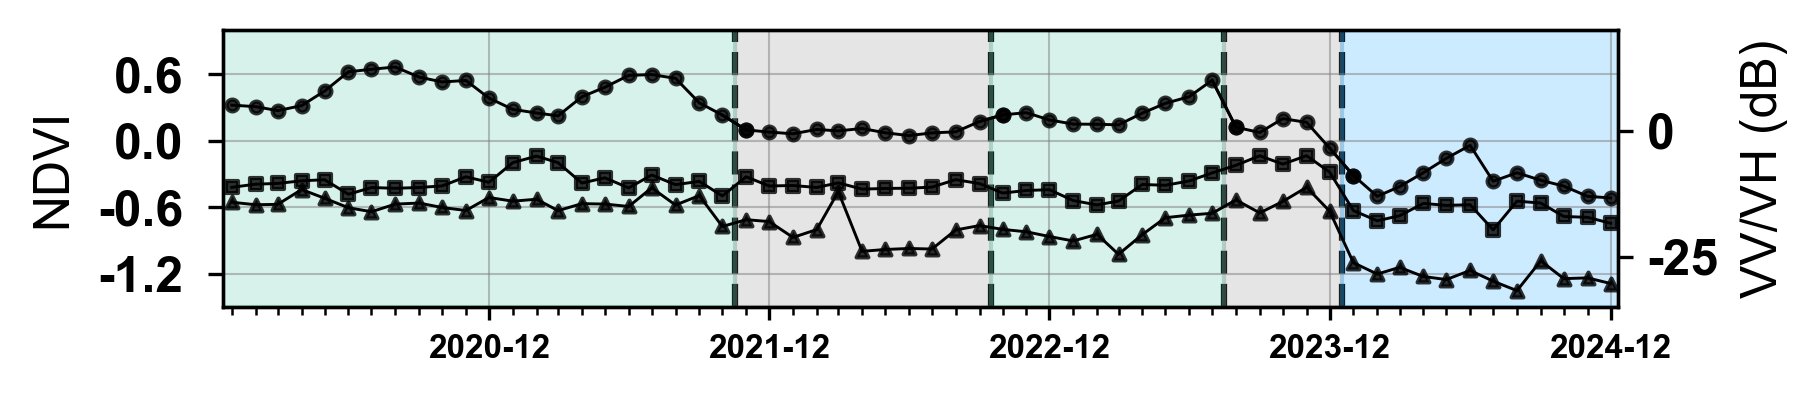

: 

In [ ]:
from matplotlib.lines import Line2D

def plot_cls_result(
    grad_cam_value=grad_cam,
    plot_grad_cam=True,
    show_lat_lon=True,
    show_event_label=True,
    fig_size=(8, 2),
    y_lim=(-0.8, 1),
    v3h_lim=(-20, 10),

):
    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=300)
    ax.set_ylabel('NDVI', fontsize=12, labelpad=5)
    ax_v3h = ax.twinx()
    ax_v3h.set_ylabel('VV/VH (dB)', fontsize=12, labelpad=5)

    # Plot NDVI
    for i in range(len(cd) - 1):
        idx_start, idx_end = dates.get_loc(cd[i]), dates.get_loc(cd[i + 1]) + 1
        color = 'black' if not plot_grad_cam else lc_clrmap[lcc[i]][0]
            
        ax.scatter(dates[idx_start: idx_end], ndvi[idx_start: idx_end],
                c=color, s=8, marker='o',zorder=99, alpha=0.8)    # s=16
        idx_start = 1 if idx_start == 0 else idx_start
        ax.plot(dates[idx_start - 1: idx_end], ndvi[idx_start - 1: idx_end], \
                c=color, linestyle='-', alpha=1, linewidth=0.7)
        
    # SAR backscatter
    for ts, label, marker in zip(list([vv, vh]), list(['VV', 'VH']), list(['s', '^'])):
        ax_v3h.scatter(dates, ts, c='black', s=8, marker=marker, zorder=99, alpha=0.8)
        ax_v3h.plot(dates, ts, color='black', linewidth=0.7, alpha=1)
    
    # Event vline
    if show_event_label: 
        for i, _ in zip(range(0, len(change_points)), hped_event):
            ax.axvline(x=dates[change_points[i]] - pd.Timedelta(days=15), 
                    linestyle='--', alpha=1, zorder=0, linewidth=1.5,
                    color="#000000")
    if not plot_grad_cam:
        cls_bg = np.insert(np.append(change_points, 59), 0, 0)
        for i in range(0, len(cls_bg)):
            if i < len(cls_bg) - 1:
                ax.axvspan(
                    xmin=dates[cls_bg[i]] - pd.Timedelta(days=15),
                    xmax=dates[cls_bg[i+1]] - pd.Timedelta(days=15) if i < len(cls_bg) - 2 else dates[cls_bg[i+1]] + pd.Timedelta(days=15),
                    color=lc_clrmap[lcc[i]][0],
                    alpha=0.2 if lc_clrmap[lcc[i]][1] != 'Herbicide-treated litter' else 0.5,
                )

    from matplotlib.ticker import MultipleLocator
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.yaxis.set_major_locator(MultipleLocator(0.6))

    # ax.tick_params(axis='x', rotation=30, labelsize=8, length=3, labelbottom=True, which='major')
    ax.tick_params(axis='x', labelsize=8, length=3, labelbottom=True, which='major')
    ax.tick_params(axis='y', pad=6)

    start_date, end_date = pd.Timestamp('2019-12-20'), pd.Timestamp('2024-12-10')
    ax.set_xlim(start_date, end_date)

    # location: lat, lon
    if show_lat_lon:
        ax.text(
            0.01, 0.05,
            f'lat, lon :  {lat_lon[1]:.4f}, {lat_lon[0]:.4f}',
            ha='left', va='bottom',
            fontsize=10,
            fontweight='bold',
            transform=ax.transAxes
        )

    ax.grid(which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.5)

    # ============================== Grad-CAM heatmap ======================================
    if plot_grad_cam:
        total_days = (end_date - start_date).days
        heatmap = grad_cam_value
        num_steps = len(heatmap) + 1
        
        norm = plt.Normalize(heatmap.min(), heatmap.max())
        cmap = plt.cm.Reds
        norm = plt.Normalize(heatmap.min(), heatmap.max())

        for i, cam_val in enumerate(heatmap):
            ratio = i / (num_steps - 1)  # normalize to [0,1]
            date_pos = start_date + pd.Timedelta(days=ratio * total_days)
            
            bar_width = total_days / (num_steps * 1)
            
            x_min = date_pos - pd.Timedelta(days=bar_width/2)
            x_max = date_pos + pd.Timedelta(days=bar_width/2)
            
            color = cmap(norm(cam_val))
            
            ax.axvspan(xmin=x_min, xmax=x_max, edgecolor='none', facecolor=color, alpha=0.8, zorder=0)
    # ===========================================================================================

    ax.set_ylim(y_lim[0], y_lim[1])
    ax_v3h.set_ylim(v3h_lim[0], v3h_lim[1])

    plt.show()

plot_cls_result(
    grad_cam_value=grad_cam,
    plot_grad_cam=False,
    show_lat_lon=False,
    show_event_label=True,
    # fig_size=(8, 1.2),
    fig_size=(6, 1.2),
    y_lim=(-1.5, 1),
    v3h_lim=(-35, 20),
)

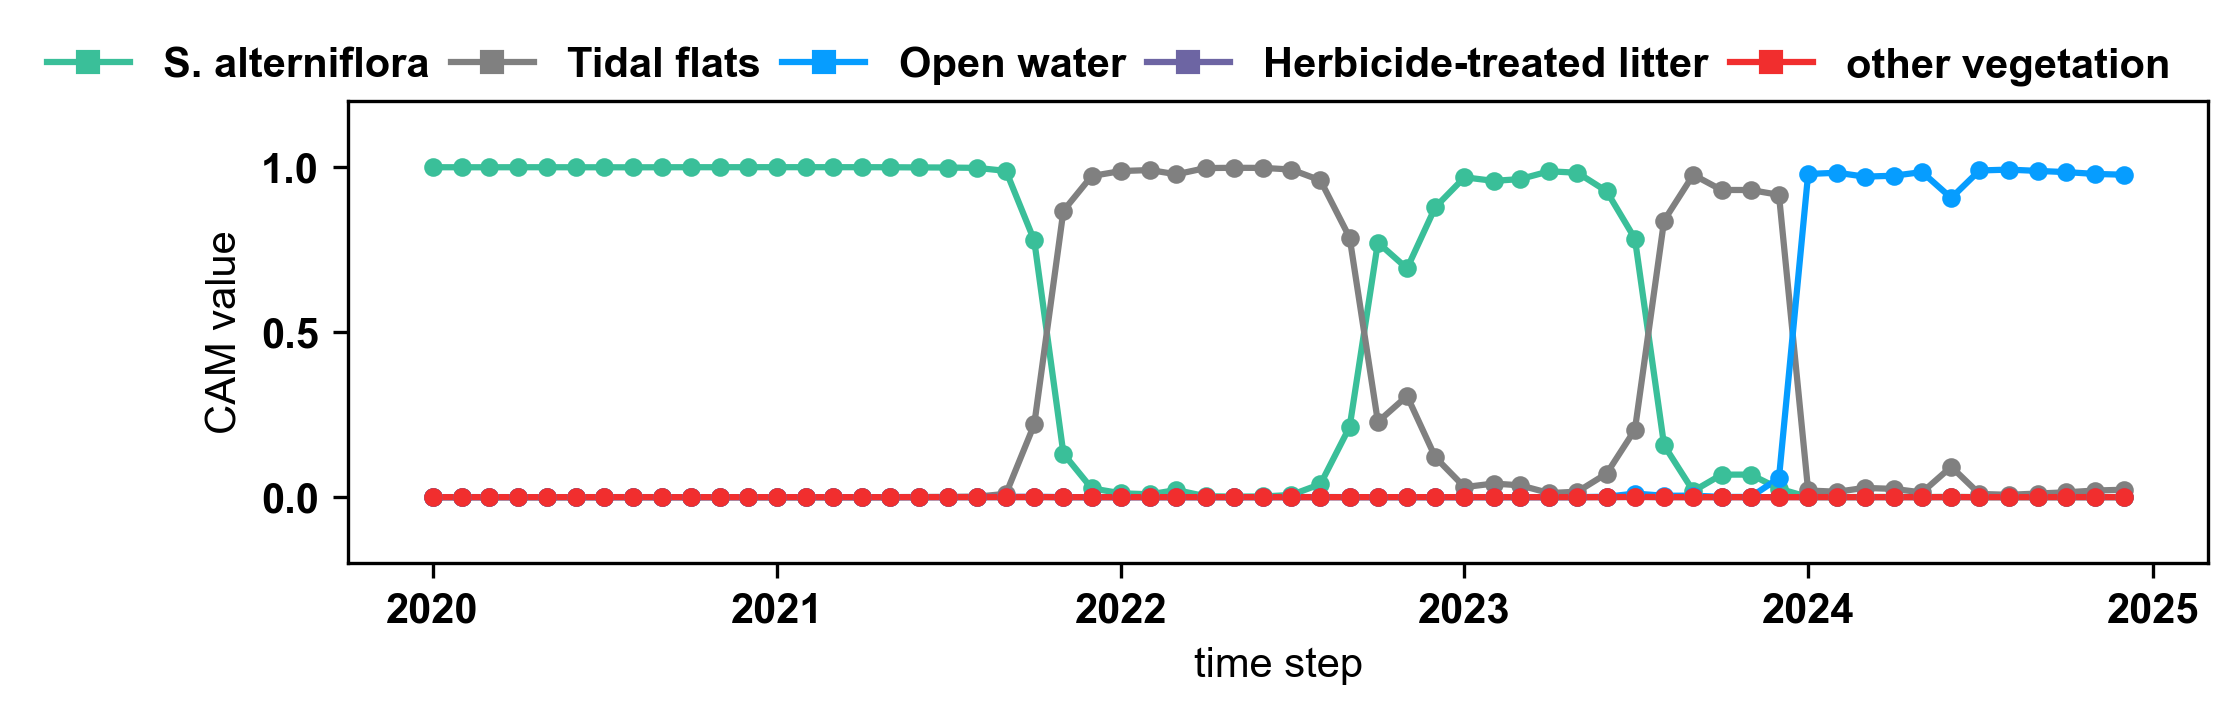

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=300)
ax.set_ylim(-0.2, 1.2)
ax.set_ylabel('probabilities distribution', fontsize=12)

lgd_elements = list()

# SAR backscatter
# for ts, clr, label in zip(list([vv, vh]), ['red', 'blue'], ['VV', 'VH']):
#     ax.scatter(dates, ts, c=clr, s=12, marker='o',zorder=99)
#     ax.plot(dates, ts, color=clr, linewidth=1.5)
#     lgd_elements.append(
#         Line2D([0], [0], color=clr[0], marker='s', linestyle='-', markersize=5, linewidth=1.5, label=label)
#     )

# Output probability
for class_prob, clr in zip(class_probs, lc_clrmap.values()):
    ax.plot(dates, class_prob, color=clr[0], linewidth=1.5)
    ax.scatter(dates, class_prob, c=clr[0], s=12, marker='o', zorder=99)
    lgd_elements.append(
        Line2D([0], [0], color=clr[0], marker='s', linestyle='-', markersize=5, linewidth=1.5, label=clr[1])
    )

ax.legend(
    handles=lgd_elements,
    loc='upper right',
    bbox_to_anchor=(1, 1.2),
    ncol=8,
    frameon=False,
    columnspacing=0.5
)
    
ax.set_xlabel('time step', fontsize=10)
ax.set_ylabel('CAM value', fontsize=10)

plt.show()


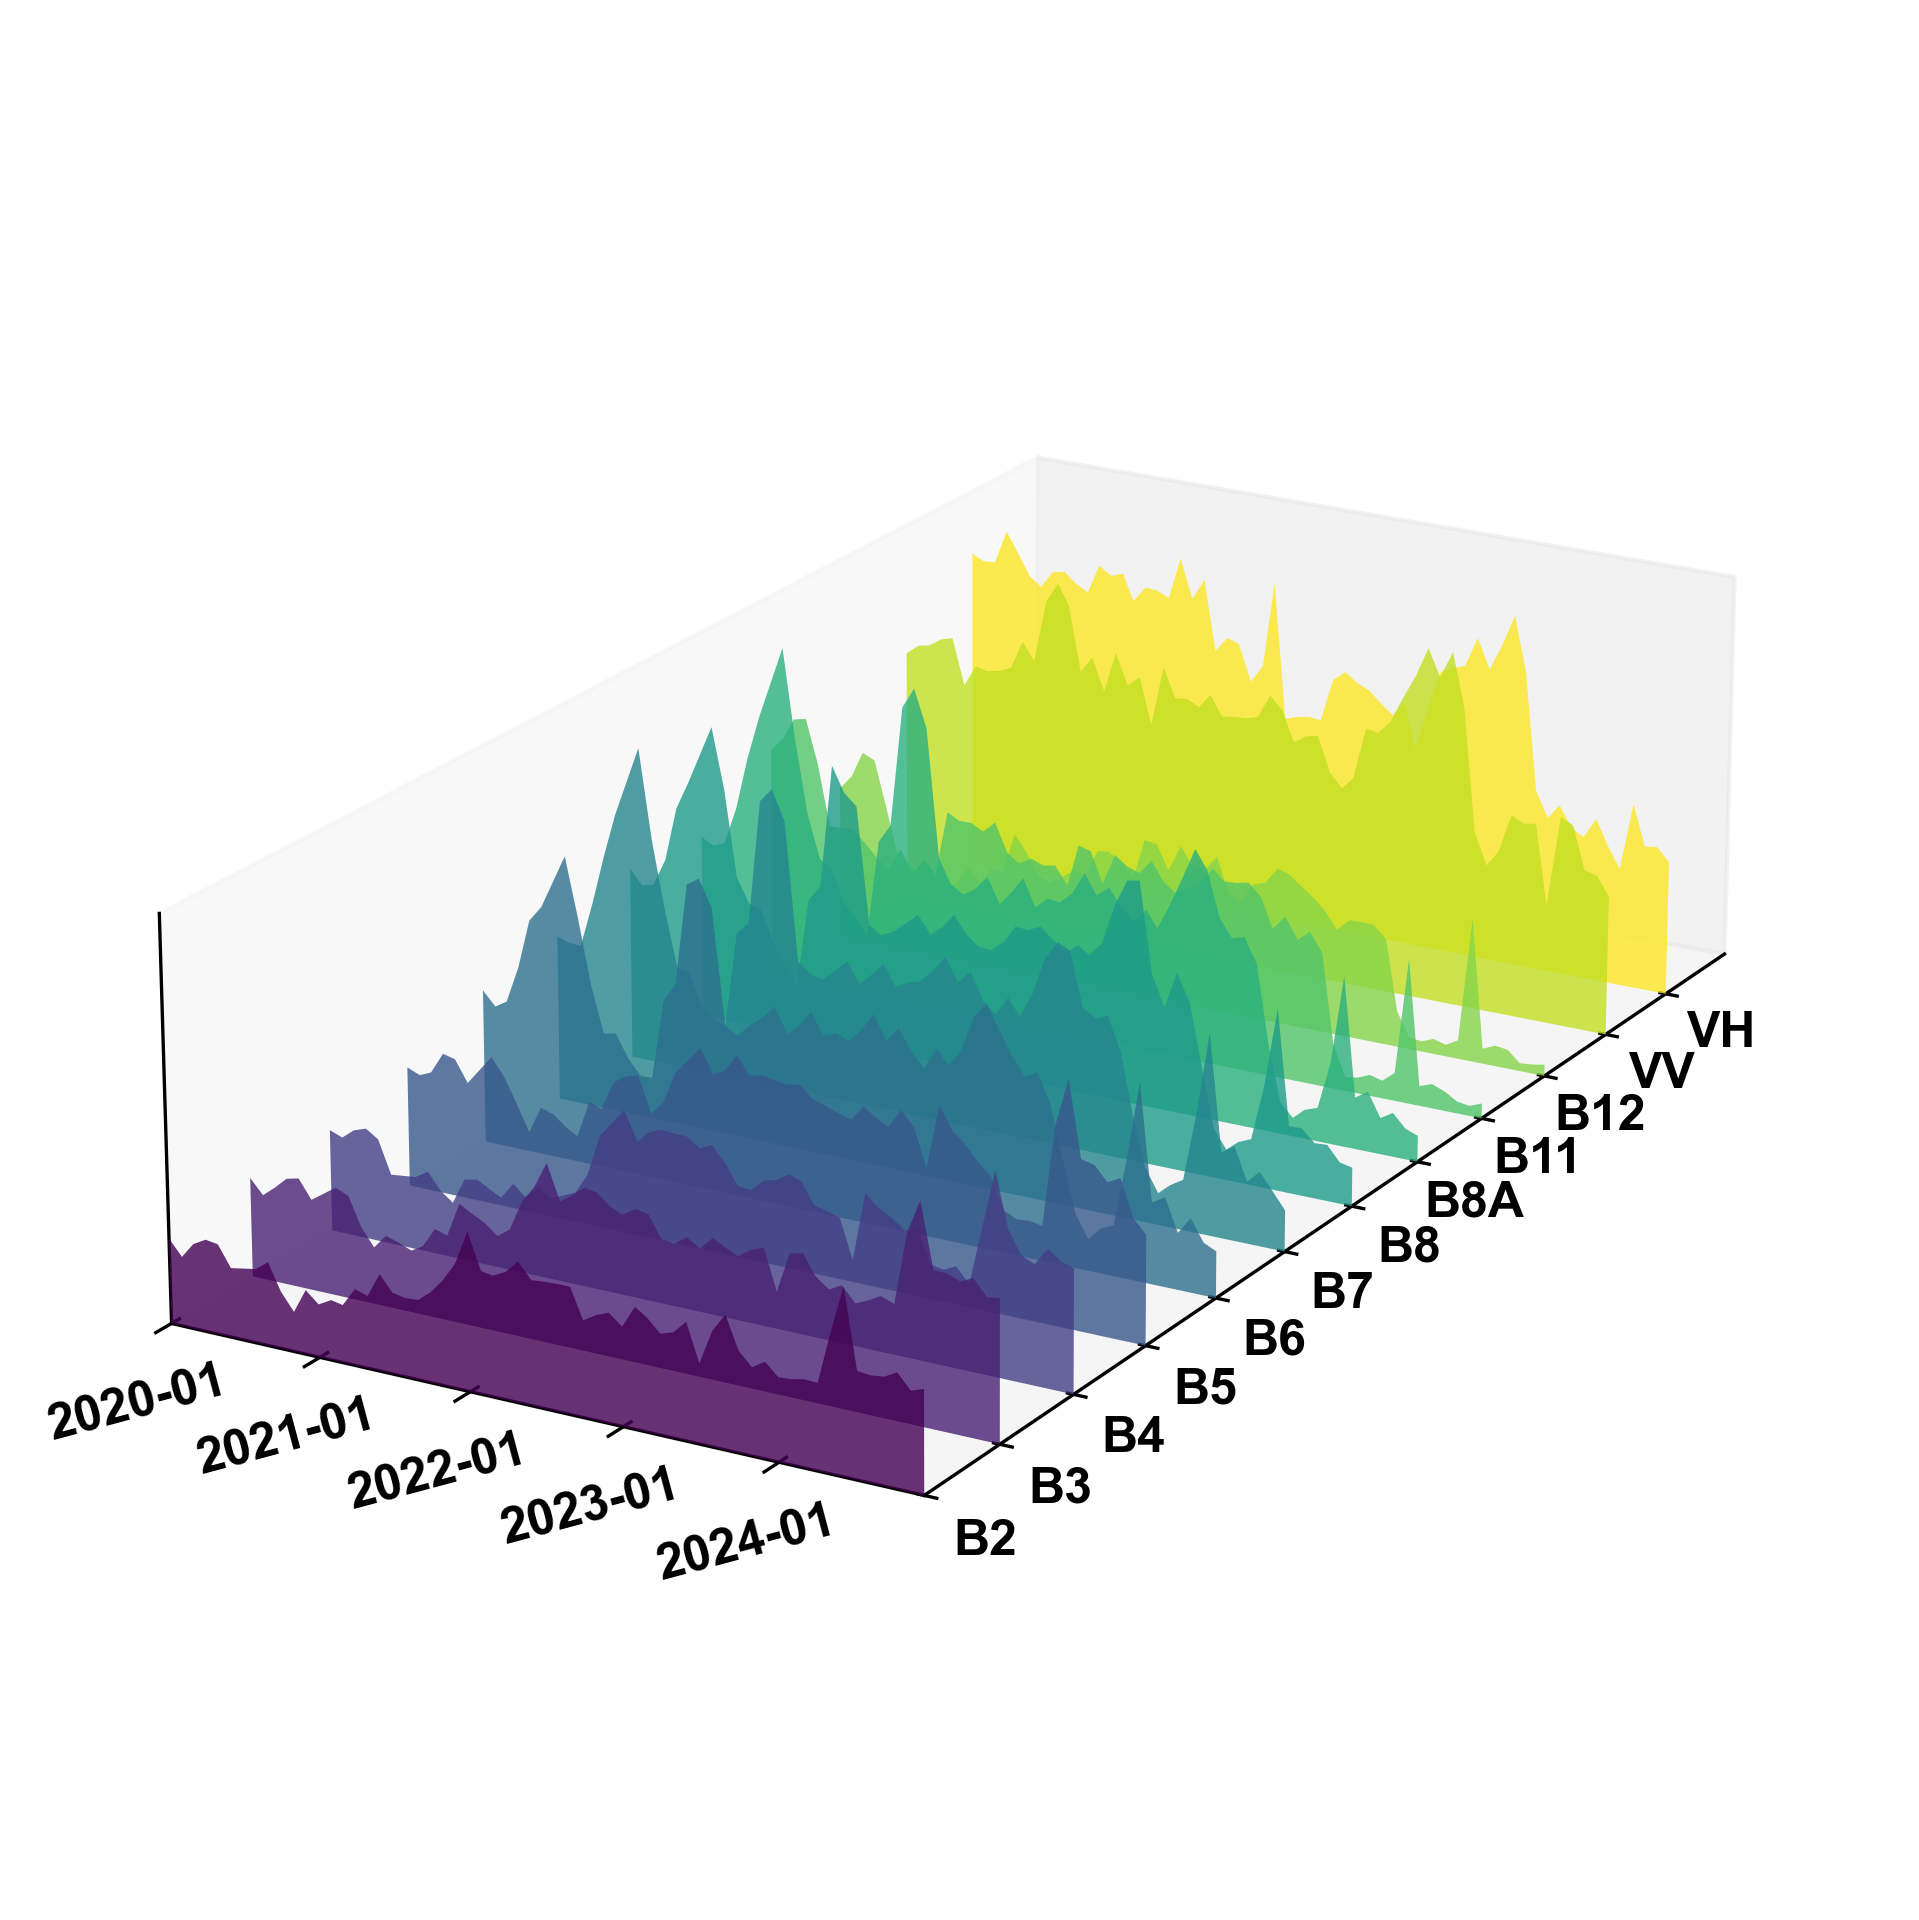

In [14]:
from mpl_toolkits.mplot3d.art3d import PolyCollection
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams['font.size'] = 12

dates_num = mdates.date2num(dates)
M, N = model_input_4_plot.shape

def scale_3vh(arr):
    return (arr - arr.min()) / (arr.max() - arr.min()) * 2000

model_input_4_plot[-1] = scale_3vh(model_input_4_plot[-1])
model_input_4_plot[-2] = scale_3vh(model_input_4_plot[-2])

OFFSET = (model_input_4_plot.max() - model_input_4_plot.min()) * 0.2
y_offsets = np.arange(M) * OFFSET

verts = list()
for i in range(M):
    xs, ys = dates_num, model_input_4_plot[i]
    if i > M - 3:
        ys = model_input_4_plot[i] + 1000
    top, bottom = list(zip(xs, ys)), list(zip(xs[::-1], np.zeros_like(ys)))
    verts.append(top + bottom)

fig = plt.figure(figsize=(8, 14), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.set_box_aspect((4, 8, 2))

colors = cm.viridis(np.linspace(0, 1, M))
poly = PolyCollection(verts, facecolors=colors, alpha=0.8)
ax.add_collection3d(poly, zs=y_offsets, zdir='y')


# ax Lim
ax.set_xlim(dates_num.min(), dates_num.max())
ax.set_ylim(y_offsets.min(), y_offsets.max() + OFFSET)
ax.set_zlim(model_input_4_plot.min(), model_input_4_plot.max())

# ax label setting 
ax.set_yticks(y_offsets)
ax.set_yticklabels(bands_label, rotation=0, va='center')
ax.tick_params(axis='y', which='major', pad=10)

ax.set_zticks([])
ax.set_zticklabels([])

ax.zaxis.set_ticks_position('lower')
ax.zaxis.set_label_position('lower')

ax.tick_params(axis='x', which='major', pad=0, rotation=15)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ax.view_init(elev=20, azim=-60, vertical_axis='z')
ax.view_init(elev=20, azim=-60, vertical_axis='z')
ax.grid(False)

plt.show()
